In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
from scipy.stats import pearsonr, spearmanr
from ta import add_all_ta_features
from ta.utils import dropna
from sklearn.preprocessing import MinMaxScaler

def analyze_technical_correlations(ticker):
    # Step 1: Download stock data
    print(f"📥 Downloading data for {ticker}...")
    end_date = datetime.today()
    start_date = end_date - relativedelta(years=10)

    df = yf.download(ticker, start=start_date, end=end_date, interval="1d", auto_adjust=True)
    if df.empty:
        print(f"❌ No data retrieved for {ticker}.")
        return

    df.reset_index(inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Step 2: Add all TA-lib indicators
    print("🧠 Computing all technical indicators...")
    df = dropna(df)
    df = add_all_ta_features(df,
                             open="Open", high="High", low="Low",
                             close="Close", volume="Volume",
                             fillna=True)

    df.reset_index(inplace=True)
    
    # Step 3: Normalize data
    print("📊 Normalizing numeric features...")
    df['Returns'] = df['Close'].pct_change()
    df['Lagged_Returns'] = df['Returns'].shift(1)
    df.dropna(inplace=True)

    scaler = MinMaxScaler()
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # Step 4: Select indicator columns (exclude target variables)
    exclude_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'Lagged_Returns']
    indicator_cols = [col for col in df.columns if col not in exclude_cols]

    # Step 5: Correlation Analysis
    print("🔍 Calculating correlations...")
    pearson_results = {'Price': {}, 'Returns': {}, 'Lagged_Returns': {}}
    spearman_results = {'Price': {}, 'Returns': {}, 'Lagged_Returns': {}}

    def calculate_correlations(data, x_col, y_col, lag=0):
        x = data[x_col].shift(lag) if lag > 0 else data[x_col]
        y = data[y_col]
        valid_data = pd.concat([x, y], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
        if len(valid_data) < 3:
            return np.nan, np.nan
        try:
            p_corr, _ = pearsonr(valid_data.iloc[:, 0], valid_data.iloc[:, 1])
            s_corr, _ = spearmanr(valid_data.iloc[:, 0], valid_data.iloc[:, 1])
            return p_corr, s_corr
        except:
            return np.nan, np.nan

    for col in indicator_cols:
        for label, y_col, lag in [('Price', 'Close', 0), ('Returns', 'Returns', 0), ('Lagged_Returns', 'Returns', 1)]:
            p_corr, s_corr = calculate_correlations(df, col, y_col, lag)
            pearson_results[label][col] = p_corr
            spearman_results[label][col] = s_corr

    pearson_df = pd.DataFrame(pearson_results)
    spearman_df = pd.DataFrame(spearman_results)

    # Step 6: Save correlation data
    # pearson_df.to_csv(f"{ticker}_pearson_correlations.csv")
    # spearman_df.to_csv(f"{ticker}_spearman_correlations.csv")

    # # Step 7: Visualize with heatmaps
    # print("📈 Creating heatmaps...")
    # plt.figure(figsize=(14, 10))
    # sns.heatmap(pearson_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    # plt.title(f"{ticker} - Pearson Correlation Heatmap")
    # plt.tight_layout()
    # plt.savefig(f"{ticker}_pearson_heatmap.png")
    # plt.show()

    # plt.figure(figsize=(14, 10))
    # sns.heatmap(spearman_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    # plt.title(f"{ticker} - Spearman Correlation Heatmap")
    # plt.tight_layout()
    # plt.savefig(f"{ticker}_spearman_heatmap.png")
    # plt.show()

    # Step 8: Show strong correlations
    print("\n📌 Significant Pearson Correlations (|corr| > 0.7):")
    # sort by absolute value
    pearson_df = pearson_df.abs().sort_values(by='Price', ascending=False)
    print(pearson_df[(pearson_df['Price'].abs() > 0.7)])
    # store them in a file 
    pearson_df[(pearson_df['Price'].abs() > 0.7)].to_csv(f"Pearsons_Coeff/{ticker}_significant_pearson.csv")

    print("\n📌 Significant Spearman Correlations (|corr| > 0.7):")
    print(spearman_df[(spearman_df['Returns'].abs() > 0.7)])



    # def plot_significant_indicators(df, indicator_list):
    #     print("\n📉 Plotting significant indicators with Close price...")
    #     df_plot = df.set_index('Date')
    #     for indicator in indicator_list:
    #         if indicator not in df_plot.columns:
    #             continue
    #         plt.figure(figsize=(14, 6))
    #         plt.plot(df_plot['Close'], label='Close Price', linewidth=2)
    #         plt.plot(df_plot[indicator], label=indicator, linestyle='--')
    #         plt.title(f"{ticker} - Close vs {indicator}")
    #         plt.xlabel("Date")
    #         plt.ylabel("Normalized Value")
    #         plt.legend()
    #         plt.tight_layout()
    #         # plt.savefig(f"{ticker}_Close_vs_{indicator}.png")
    #         plt.show()

    # significant_indicators = pearson_df.index[pearson_df['Price'].abs() > 0.7].tolist()
    # plot_significant_indicators(df, significant_indicators)


In [5]:
analyze_technical_correlations("TCS.NS")  #Large Cap IT
# # analyze_technical_correlations("INFY.NS") #large Cap IT
# # analyze_technical_correlations("WIPRO.NS")  #Large Cap IT
# # analyze_technical_correlations("HCLTECH.NS") # Large Cap IT
# # Mid Cap IT
# # analyze_technical_correlations("TECHM.NS")  # Mid Cap IT
# analyze_technical_correlations("PERSISTENT.NS")  # Mid Cap IT
# # Small Cap IT
# analyze_technical_correlations("LTIM.NS")  # Small Cap IT


📥 Downloading data for TCS.NS...


[*********************100%***********************]  1 of 1 completed
/Users/utsavdhanuka/miniconda3/envs/env_pytorch/lib/python3.9/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


🧠 Computing all technical indicators...
📊 Normalizing numeric features...
🔍 Calculating correlations...

📌 Significant Pearson Correlations (|corr| > 0.7):
                            Price   Returns  Lagged_Returns
others_cr                1.000000  0.005763        0.025927
trend_ema_fast           0.998584  0.019974        0.024895
trend_ichimoku_conv      0.998569  0.018898        0.025088
momentum_kama            0.998330  0.020463        0.024916
volatility_kcc           0.998238  0.022439        0.024829
volatility_kcl           0.998175  0.022699        0.025091
volatility_kch           0.998150  0.022183        0.024572
trend_sma_fast           0.998002  0.022117        0.024746
volume_vwap              0.997823  0.021529        0.024411
trend_ichimoku_a         0.997783  0.019544        0.024538
volatility_dcm           0.996941  0.019422        0.023719
trend_ema_slow           0.996836  0.021358        0.023769
volatility_bbm           0.996610  0.022477        0.024112
vola

SENSITIVITY ANALYSIS

In [1]:
def sensitivity_analysis(ticker, period=1):
    import pandas as pd
    import numpy as np
    import yfinance as yf
    import matplotlib.pyplot as plt
    from ta import add_all_ta_features
    from ta.utils import dropna
    from datetime import datetime
    from dateutil.relativedelta import relativedelta
    from scipy.stats import zscore

    print(f"📥 Downloading data for {ticker}...")
    end_date = datetime.today()
    start_date = end_date - relativedelta(years=10)

    df = yf.download(ticker, start=start_date, end=end_date, interval="1d", auto_adjust=True)
    if df.empty:
        print(f"❌ No data retrieved for {ticker}.")
        return

    df.reset_index(inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Step 2: Add technical indicators
    print("🧠 Computing all technical indicators...")
    df = dropna(df)
    df = add_all_ta_features(df,
                             open="Open", high="High", low="Low",
                             close="Close", volume="Volume",
                             fillna=True)
    df.reset_index(inplace=True)

    # Z-score normalization for numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].apply(zscore)
    df.dropna(inplace=True)

    # Calculate price change
    df['Price_Change'] = df['Close'].diff(periods=period)
    df.dropna(inplace=True)

    # Identify indicator columns (exclude OHLCV and computed returns)
    exclude_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change']
    indicator_cols = [col for col in df.columns if col not in exclude_cols]

    # Compute sensitivity scores
    sensitivity_scores = {}

    for col in indicator_cols:
        if df[col].isnull().any():
            continue
        df[f'{col}_Change'] = df[col].diff(periods=period)
        df_filtered = df[[f'{col}_Change', 'Price_Change']].replace([np.inf, -np.inf], np.nan).dropna()

        # Avoid divide-by-zero
        df_filtered = df_filtered[df_filtered[f'{col}_Change'] != 0]

        if df_filtered.empty:
            sensitivity_scores[col] = np.nan
            continue

        # Clip extreme values to prevent distortion
        sensitivities = (df_filtered['Price_Change'] / df_filtered[f'{col}_Change']).clip(lower=-10, upper=10)
        sensitivity_scores[col] = sensitivities.mean()

    # Construct sensitivity DataFrame
    sensitivity_df = pd.DataFrame.from_dict(sensitivity_scores, orient='index', columns=['Average_Sensitivity'])
    sensitivity_df.dropna(inplace=True)

    # Compute Z-score of sensitivities
    sensitivity_df['Zscore_Sensitivity'] = zscore(sensitivity_df['Average_Sensitivity'])

    # Sort for visualization
    sensitivity_df.sort_values(by='Average_Sensitivity', ascending=False, inplace=True)
    top_raw = sensitivity_df.head(20)

    sensitivity_df.sort_values(by='Zscore_Sensitivity', ascending=False, inplace=True)
    top_zscore = sensitivity_df.head(20)

    # --- Plot Raw + Z-score Side-by-Side ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot 1: Raw Sensitivity Scores
    # top_raw['Average_Sensitivity'].plot(kind='bar', ax=axes[0])
    # axes[0].set_title(f"{ticker} - Top 20 Raw Sensitivity Scores")
    # axes[0].set_ylabel("Average ΔPrice / ΔIndicator")
    # axes[0].set_xlabel("Technical Indicator")
    # axes[0].tick_params(axis='x', rotation=90)
    # axes[0].grid(True)

    # Plot 2: Z-score Normalized Sensitivity
    top_zscore['Zscore_Sensitivity'].plot(kind='bar', ax=axes[1], color='orange')
    axes[1].set_title(f"{ticker} - Top 20 Normalized (Z-score) Sensitivity")
    axes[1].set_ylabel("Z-score of Sensitivity")
    axes[1].set_xlabel("Technical Indicator")
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(f"{ticker}_sensitivity_comparison.png")
    plt.show()

    # 📋 Print top 20 indicators
    print("\n📌 Top 20 Indicators by Raw Average Sensitivity:")
    print(top_raw[['Average_Sensitivity']])

    print("\n📌 Top 20 Indicators by Z-score Normalized Sensitivity:")
    print(top_zscore[['Zscore_Sensitivity']])
    # store top 20 Z-score indicators in a file
    top_zscore[['Zscore_Sensitivity']].to_csv(f"Sensitivity_Zscores/{ticker}_top_sensitivity_indicators.csv")

    # Optional: Save to CSV
    # sensitivity_df.to_csv(f"{ticker}_sensitivity_scores.csv")

    return sensitivity_df


📥 Downloading data for TCS.NS...


[*********************100%***********************]  1 of 1 completed
/Users/utsavdhanuka/miniconda3/envs/env_pytorch/lib/python3.9/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


🧠 Computing all technical indicators...


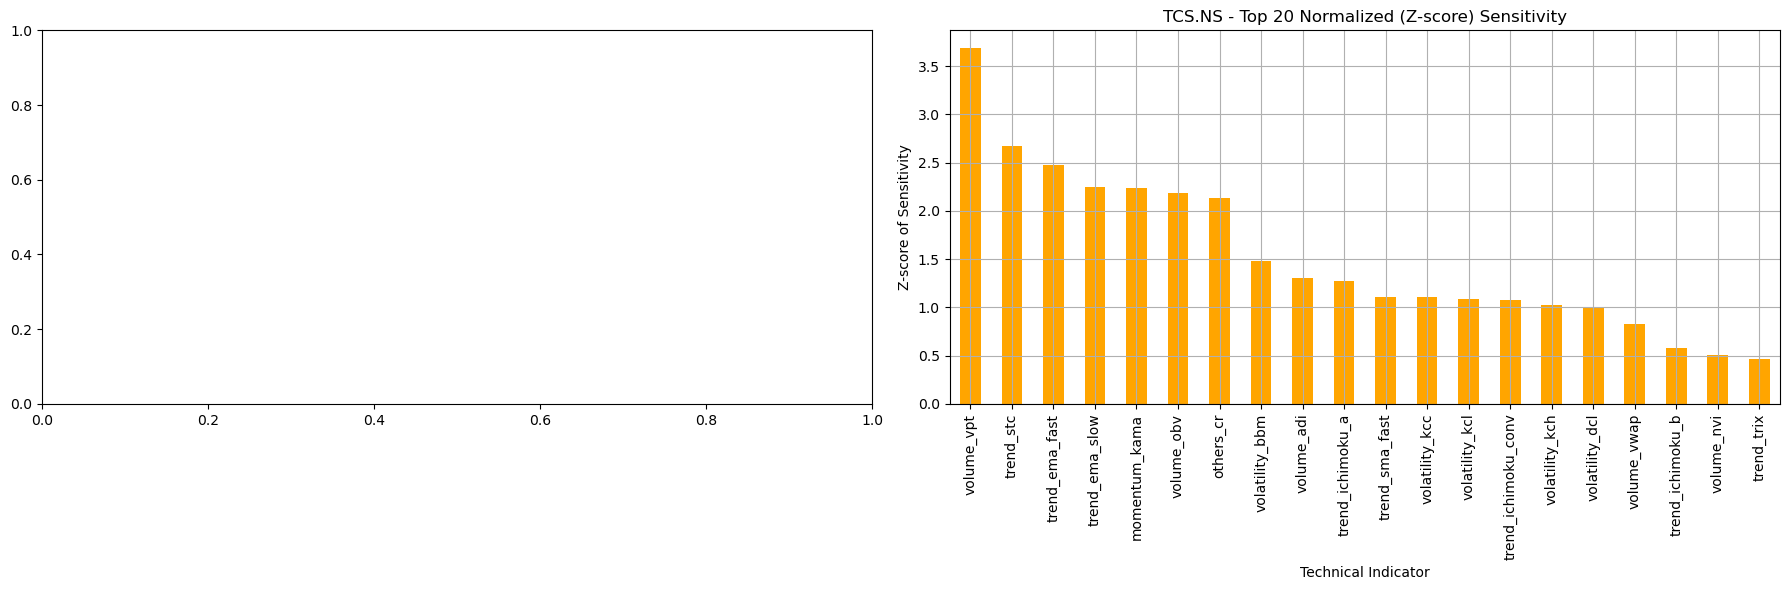


📌 Top 20 Indicators by Raw Average Sensitivity:
                     Average_Sensitivity
volume_vpt                      1.582794
trend_stc                       1.202446
trend_ema_fast                  1.129036
trend_ema_slow                  1.040828
momentum_kama                   1.036342
volume_obv                      1.018751
others_cr                       1.000000
volatility_bbm                  0.751221
volume_adi                      0.687594
trend_ichimoku_a                0.674153
trend_sma_fast                  0.613138
volatility_kcc                  0.612153
volatility_kcl                  0.603938
trend_ichimoku_conv             0.601797
volatility_kch                  0.579752
volatility_dcl                  0.573221
volume_vwap                     0.508491
trend_ichimoku_b                0.412048
volume_nvi                      0.385523
trend_trix                      0.371228

📌 Top 20 Indicators by Z-score Normalized Sensitivity:
                     Zscore_Sensit

,Average_Sensitivity,Zscore_Sensitivity
volume_vpt,1.582794,3.688094
trend_stc,1.202446,2.676513
trend_ema_fast,1.129036,2.481270
trend_ema_slow,1.040828,2.246671
momentum_kama,1.036342,2.234738
...,...,...
volatility_ui,-0.079973,-0.734235
trend_vortex_ind_neg,-0.085857,-0.749887
trend_adx_neg,-0.087668,-0.754703
trend_psar_up,-0.540306,-1.958548


In [2]:
sensitivity_analysis("TCS.NS", period=5)
# sensitivity_analysis("INFY.NS", period=5)
# sensitivity_analysis("WIPRO.NS", period=5)
# sensitivity_analysis("HCLTECH.NS", period=5)
# sensitivity_analysis("TECHM.NS", period=5)
# sensitivity_analysis("PERSISTENT.NS", period=5)
# sensitivity_analysis("LTIM.NS", period=5)

Analayse all Pearsons Files and select top 7 common for all stocks 

In [21]:
# loop through all {ticker}_significant_pearson.csv files in the Pearsons_Coeff directory and get the best 7 indicators for all takiing common indicators

import os
def get_best_indicators_from_files(directory, top_n=7):
    all_indicators = {}
    
    for filename in os.listdir(directory):
        if filename.endswith("_significant_pearson.csv"):
            ticker = filename.split('_')[0]
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path, index_col=0)
            
            # Get the top indicators for this ticker
            top_indicators = df.index[df['Price'].abs() > 0.95].tolist()
            print(f"📊 {ticker} - Found {len(top_indicators)} significant indicators.")
            all_indicators[ticker] = top_indicators
            
    # Find common indicators across all tickers
    common_indicators = set.intersection(*[set(indicators) for indicators in all_indicators.values()])
    
    # Get the best N indicators from the common ones
    best_indicators = list(common_indicators)[:top_n]
    
    return best_indicators
best_indicators = get_best_indicators_from_files("Pearsons_Coeff", top_n=12)
print("\n📌 Best 10 Common Indicators Across All Tickers:")
print(best_indicators)
# save the best indicators to a file
with open("best_indicators.txt", "w") as f:
    for indicator in best_indicators:
        f.write(f"{indicator}\n")
   

📊 TCS.NS - Found 25 significant indicators.
📊 INFY.NS - Found 24 significant indicators.
📊 LTIM.NS - Found 26 significant indicators.
📊 WIPRO.NS - Found 24 significant indicators.
📊 PERSISTENT.NS - Found 24 significant indicators.
📊 HCLTECH.NS - Found 24 significant indicators.
📊 TECHM.NS - Found 25 significant indicators.

📌 Best 10 Common Indicators Across All Tickers:
['volume_vwap', 'trend_ema_fast', 'trend_ichimoku_conv', 'trend_visual_ichimoku_a', 'others_cr', 'trend_psar_down', 'volatility_kcl', 'trend_sma_slow', 'trend_ichimoku_a', 'volatility_kch', 'trend_ichimoku_b', 'momentum_kama']


In [20]:
# loop through all {ticker}_top_sensitivity_indicators.csv files in the Pearsons_Coeff directory and get the best 7 indicators for all takiing common indicators

def get_best_sensitivity_indicators_from_files(directory, top_n=7):
    all_indicators = {}
    for filename in os.listdir(directory):
        if filename.endswith("_top_sensitivity_indicators.csv"):
            ticker = filename.split('_')[0]
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path, index_col=0)

            # Get the top indicators for this ticker
            top_indicators = df.index.tolist()
            all_indicators[ticker] = top_indicators

    # find common indicators across all tickers
    common_indicators = set.intersection(*[set(indicators) for indicators in all_indicators.values()])
    # Get the best N indicators from the common ones
    best_indicators = list(common_indicators)[:top_n]
    return best_indicators

best_sensitivity_indicators = get_best_sensitivity_indicators_from_files("Sensitivity_Zscores", top_n=12)
print("\n📌 Best 7 Common Sensitivity Indicators Across All Tickers:")
print(best_sensitivity_indicators)
# save the best sensitivity indicators to a file
with open("best_sensitivity_indicators.txt", "w") as f:
    for indicator in best_sensitivity_indicators:
        f.write(f"{indicator}\n")



📌 Best 7 Common Sensitivity Indicators Across All Tickers:
['volatility_kcl', 'volatility_kch', 'volatility_dcl', 'trend_stc', 'trend_ema_slow', 'trend_ema_fast', 'momentum_kama', 'trend_ichimoku_conv', 'volume_obv', 'volume_vpt', 'others_cr', 'trend_sma_fast']
